Installing pyspark library

In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5c02a6833fc51601f93952b6a8909844e4cbe3e883374686e880235afbbb1781
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Running Spark session locally, configuring the session and creating a spark context

In [4]:
# Create a PySpark session
from pyspark.sql import SparkSession
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("ML TenYearCHD risk Pred")\
    .getOrCreate()
sc = spark.sparkContext

Importing the framingham dataset

In [5]:
fhd_df = spark.read.csv('/content/Cleaned Framingham Dataset.csv', header = True, inferSchema = True)
fhd_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- currentSmoker: integer (nullable = true)
 |-- cigsPerDay: integer (nullable = true)
 |-- BPMeds: integer (nullable = true)
 |-- prevalentStroke: integer (nullable = true)
 |-- prevalentHyp: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- totChol: integer (nullable = true)
 |-- sysBP: double (nullable = true)
 |-- diaBP: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- heartRate: integer (nullable = true)
 |-- glucose: integer (nullable = true)
 |-- TenYearCHD: integer (nullable = true)



Looking at the first 6 observations using the pandas dataframe, here the numbering begins from zero

In [ ]:
import pandas as pd
pd.DataFrame(fhd_df.take(6), columns = fhd_df.columns)

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,male,39,PHD,0,0,0,0,0,0,195,106.0,70.0,26.97,80,77,0
1,female,46,Graduation,0,0,0,0,0,0,250,121.0,81.0,28.73,95,76,0
2,male,48,Secondary School,1,20,0,0,0,0,245,127.5,80.0,25.34,75,70,0
3,female,61,Post Graduation,1,30,0,0,1,0,225,150.0,95.0,28.58,65,103,1
4,female,46,Post Graduation,1,23,0,0,0,0,285,130.0,84.0,23.10,85,85,0
5,female,43,Graduation,0,0,0,0,1,0,228,180.0,110.0,30.30,77,99,0


Inspecting the spread of our target category levels

In [6]:
fhd_df.groupby('TenYearCHD').count().toPandas()

,TenYearCHD,count
0,1,557
1,0,3099


Inspecting numerical variables

In [7]:
num_fhd = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
fhd_df.select(num_fhd).describe().toPandas()

,summary,age,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,count,3656,3656,3656,3656,3656,3656,3656,3656
1,mean,49.5574398249453,9.022155361050329,236.87308533916848,132.3680251641138,82.91206236323852,25.78418490153166,75.73057986870897,81.85612691466083
2,stddev,8.561133464288977,11.918868525423688,44.09622332488073,22.092443955554682,11.974825143730586,4.065912664131021,11.982952108022781,23.91012768583009
3,min,32,0,113,83.5,48.0,15.54,44,40
4,max,70,70,600,295.0,142.5,56.8,143,394


Correlation plot for all numerical variables shows a correlation between systolic and diastolic BP. Unlike the R implementation, the scatterplot matrix utilizes blue as its default colour and there is a histogram which represents the count for each numerical variable, displaying the spread of the distribution.

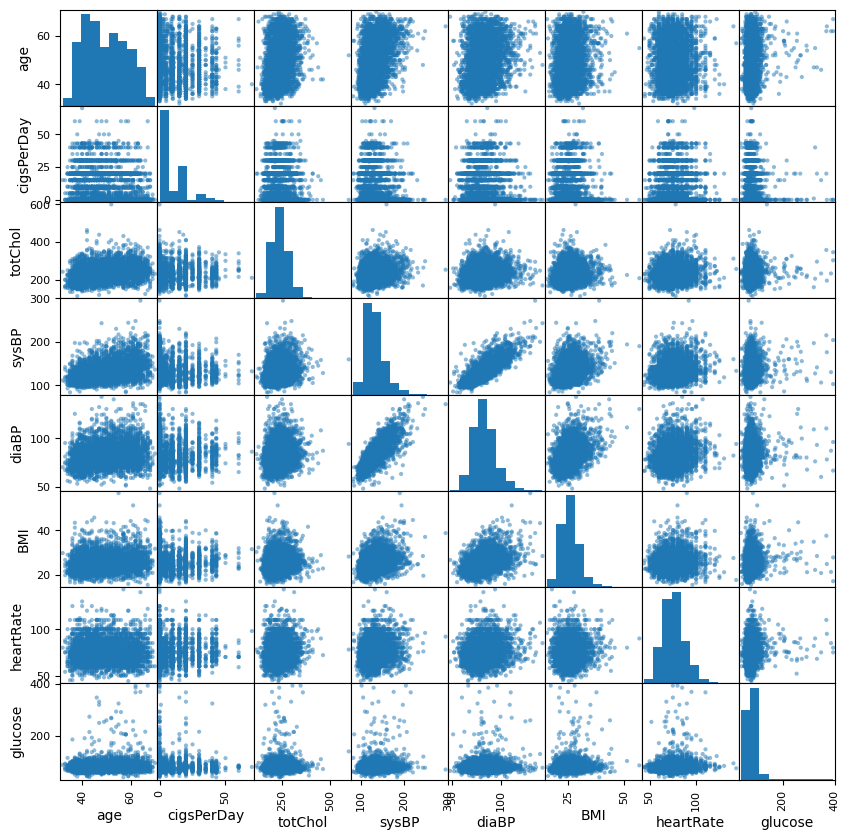

In [8]:
from pandas.plotting import scatter_matrix
num_fhd_data = fhd_df.select(num_fhd).toPandas()
axs = scatter_matrix(num_fhd_data, figsize = (10, 10))

One hot encoding for the categrical variables

In [9]:
# import the required functions
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# Storing all categorical variables
cat_fhd = ['gender', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']

# Empty list that will be used to contain the results of StringIndexer and OneHotEncoder
stages = []

# Making Target variablbe a string
#from pyspark.sql.functions import col
#fhd_df = fhd_df.withColumn('TenYearCHD', col('TenYearCHD').cast('string'))

Indexing each categorical variable and converting each indexed category to one hot encoded variable

In [11]:
for categoricalCol in cat_fhd:
    Strindex = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encode = OneHotEncoder(inputCols=[Strindex.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages = stages + [Strindex, encode]
#Use stringindexer again for the labels
label_stringIdx = StringIndexer(inputCol='TenYearCHD', outputCol='label')
stages.append(label_stringIdx)


Using the VectorAssembler to combine all the feature columns into a single vector column

In [12]:
assemblerInputs = [c + "classVec" for c in cat_fhd] + num_fhd
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
stages.append(assembler)
#stages = stages + [assembler]

Applying the pipeline

In [13]:
# import Pipeline
from pyspark.ml import Pipeline

cols = fhd_df.columns
# steps to create the ML pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(fhd_df)
fhd_df = pipelineModel.transform(fhd_df)

In [14]:
selectedCols = ['label', 'features'] + fhd_df.columns
#fhd_df = fhd_df.select(selectedCols)
fhd_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- currentSmoker: integer (nullable = true)
 |-- cigsPerDay: integer (nullable = true)
 |-- BPMeds: integer (nullable = true)
 |-- prevalentStroke: integer (nullable = true)
 |-- prevalentHyp: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- totChol: integer (nullable = true)
 |-- sysBP: double (nullable = true)
 |-- diaBP: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- heartRate: integer (nullable = true)
 |-- glucose: integer (nullable = true)
 |-- TenYearCHD: integer (nullable = true)
 |-- genderIndex: double (nullable = false)
 |-- genderclassVec: vector (nullable = true)
 |-- educationIndex: double (nullable = false)
 |-- educationclassVec: vector (nullable = true)
 |-- currentSmokerIndex: double (nullable = false)
 |-- currentSmokerclassVec: vector (nullable = true)
 |-- BPMedsIndex: double (nullable = false)
 |-- BPMed

Creating the boxplots.

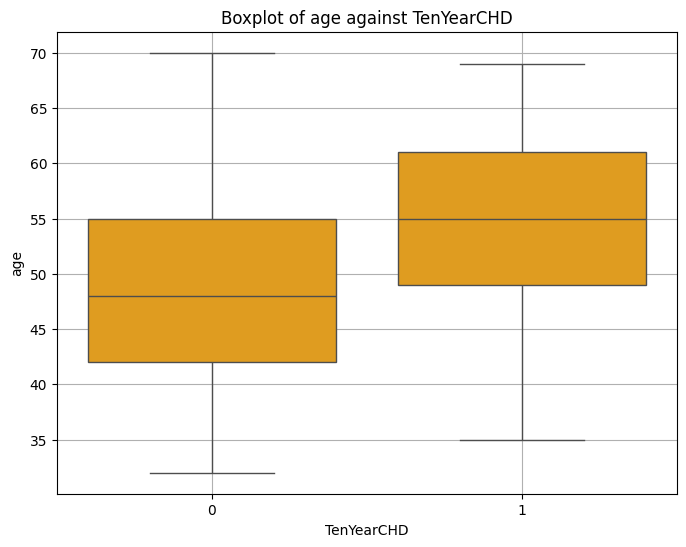

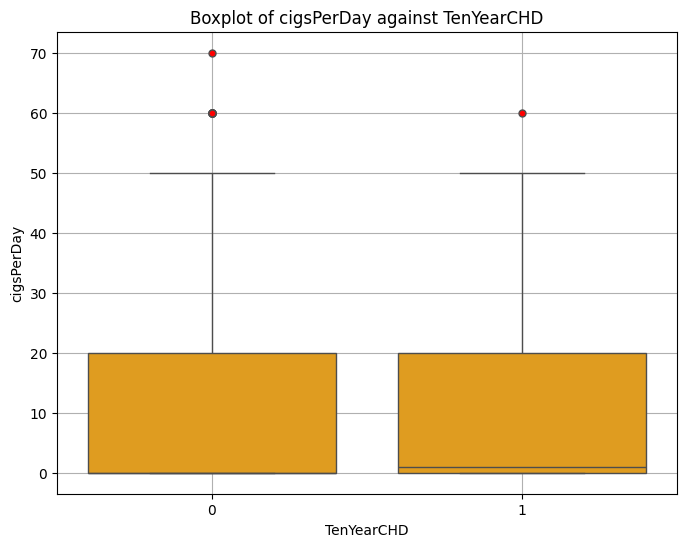

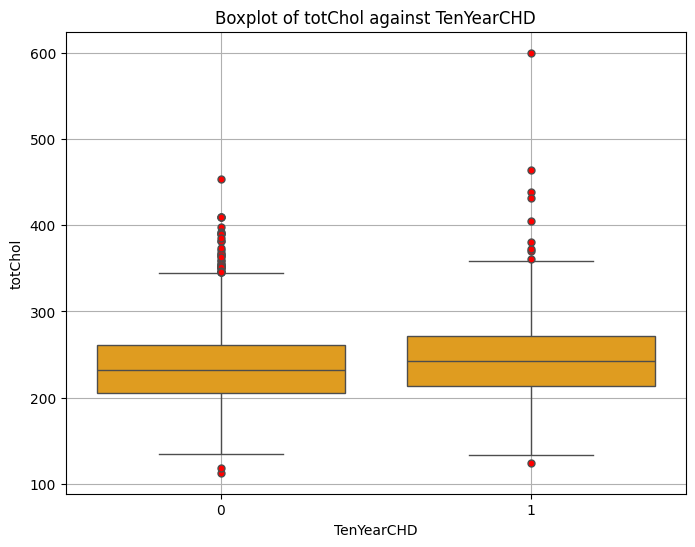

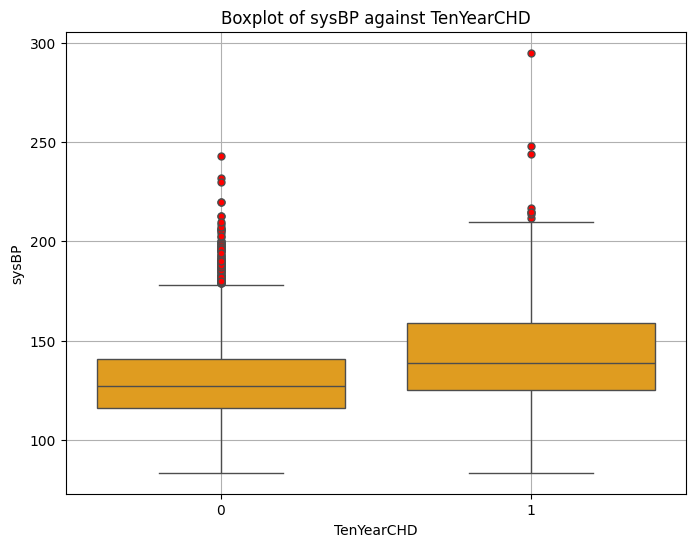

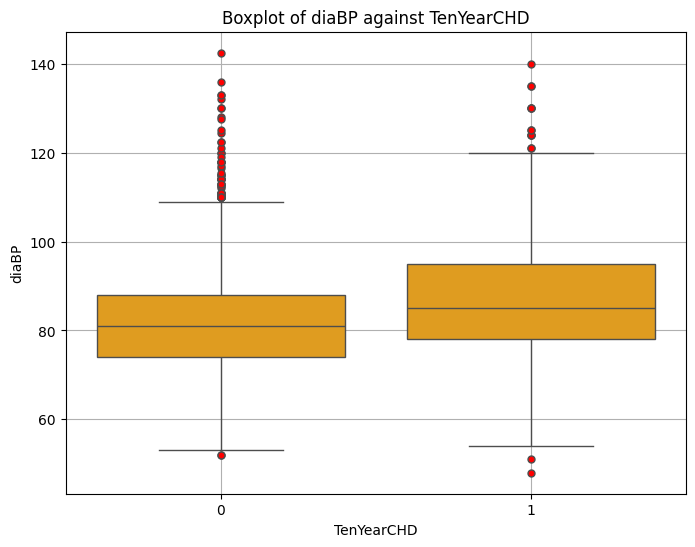

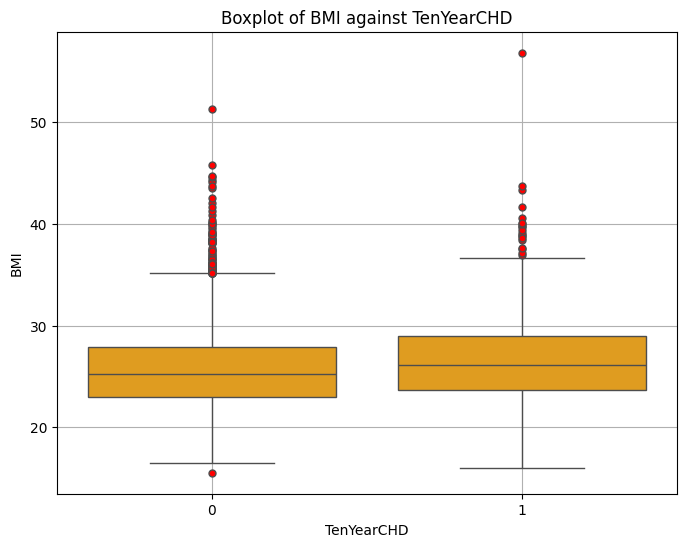

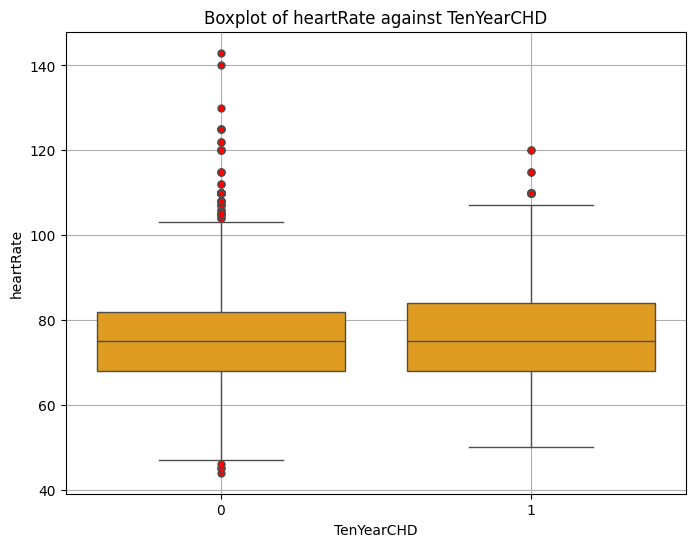

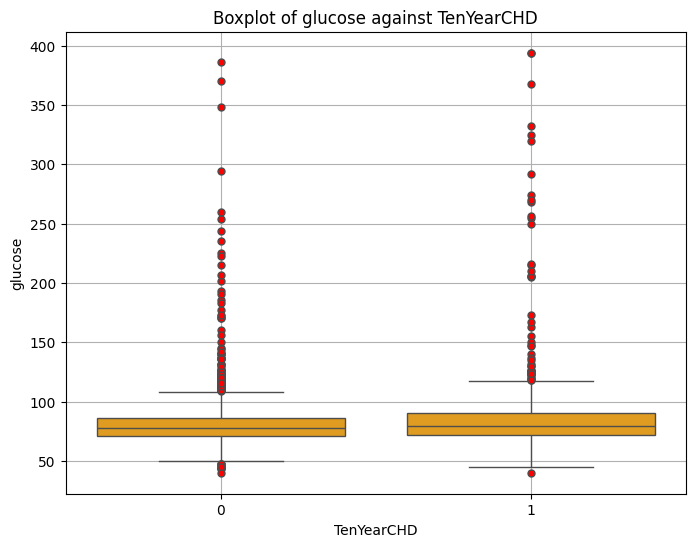

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def num_against_tar(x):
    plt.figure(figsize=(8, 6))  # Setting the figure size for each plot
    sns.boxplot(data=fhd_df.toPandas(), x='TenYearCHD', y=x, color='orange', flierprops=dict(marker='o', markersize=5, markerfacecolor='red'))
    plt.xlabel('TenYearCHD')
    plt.ylabel(x)
    plt.grid(True)
    plt.title(f'Boxplot of {x} against TenYearCHD')  # Setting a title for each plot
    plt.show()  

# Applying the function to each numeric variable
for col in num_fhd_data.columns:
    num_against_tar(col)


Mosaic plot for categorical varaibles against target variable. There is a default green and maroon aesthetic.

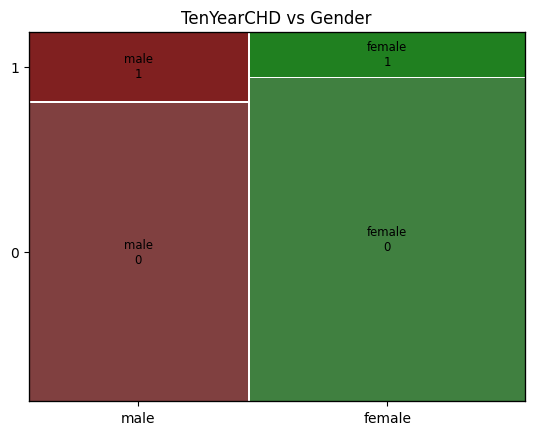

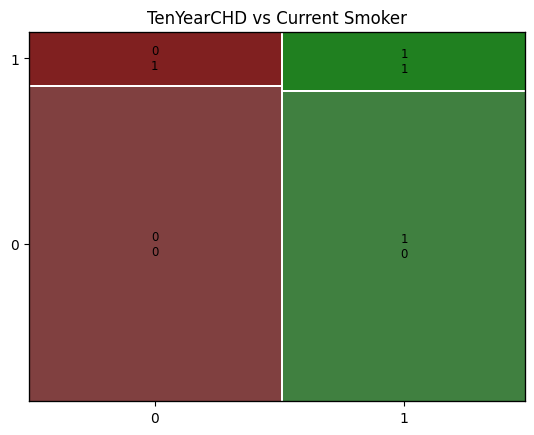

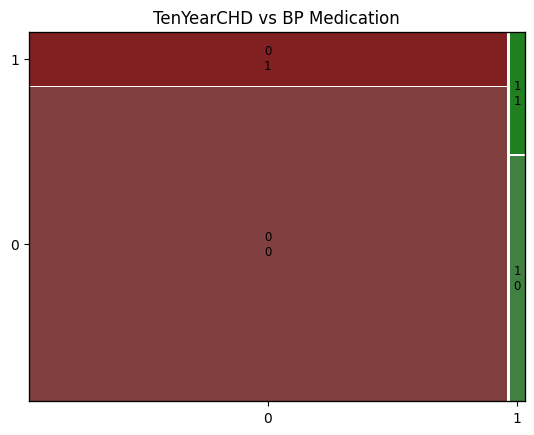

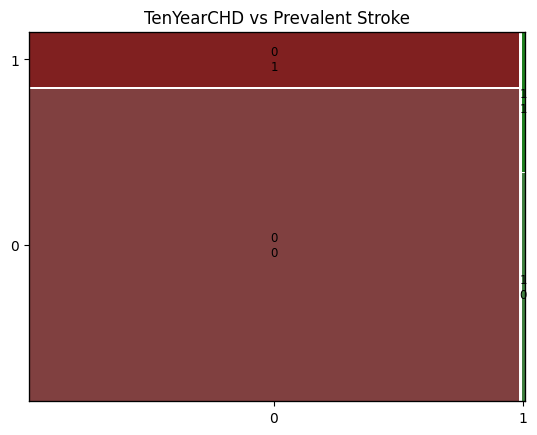

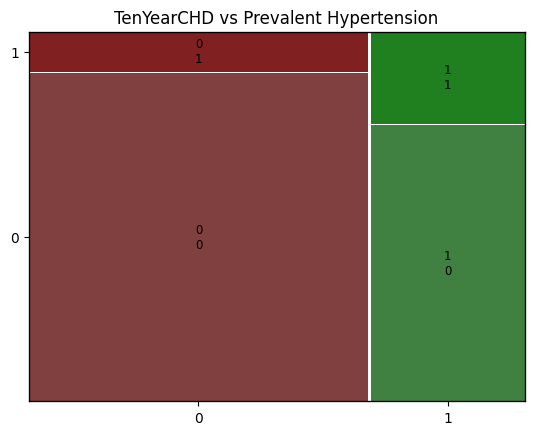

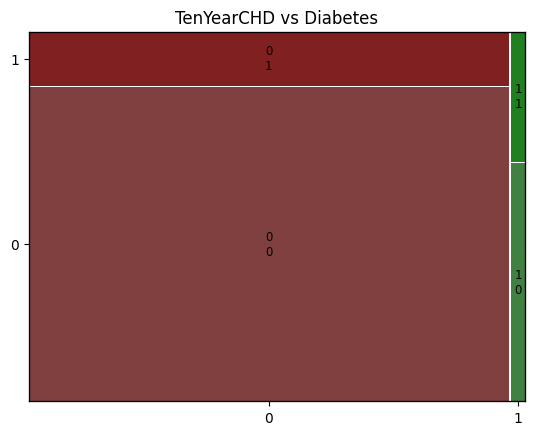

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.mosaicplot import mosaic

# Converting PySpark DataFrame to Pandas DataFrame
fhd_pd_df = fhd_df.toPandas()

# Creating mosaic plots
mosaic(fhd_pd_df, ['gender', 'TenYearCHD'])
plt.title('TenYearCHD vs Gender')
plt.show()

mosaic(fhd_pd_df, ['currentSmoker', 'TenYearCHD'])
plt.title('TenYearCHD vs Current Smoker')
plt.show()

mosaic(fhd_pd_df, ['BPMeds', 'TenYearCHD'])
plt.title('TenYearCHD vs BP Medication')
plt.show()

mosaic(fhd_pd_df, ['prevalentStroke', 'TenYearCHD'])
plt.title('TenYearCHD vs Prevalent Stroke')
plt.show()

mosaic(fhd_pd_df, ['prevalentHyp', 'TenYearCHD'])
plt.title('TenYearCHD vs Prevalent Hypertension')
plt.show()

mosaic(fhd_pd_df, ['diabetes', 'TenYearCHD'])
plt.title('TenYearCHD vs Diabetes')
plt.show()


Applying PCA to numerical variables.

In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

num_fhd_df = fhd_df.select([col for col, dtype in fhd_df.dtypes if dtype == 'int' or dtype == 'double'])

# Selecting only the required columns
selected_columns = ['age', 'cigsPerDay', 'totChol', 'heartRate', 'glucose', 'BMI', 'sysBP', 'diaBP']
num_fhd_df_for_pca = num_fhd_df.select(*selected_columns)

# Assemble the numerical variables into a single vector column
assembler = VectorAssembler(inputCols=num_fhd_df_for_pca.columns, outputCol="features")
assembled_data = assembler.transform(num_fhd_df_for_pca)

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

# Apply PCA
pca = PCA(k=len(num_fhd_df_for_pca.columns), inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_data)
explained_variance = pca_model.explainedVariance.toArray()



In [95]:
from pyspark.sql.types import FloatType

# Transformed PC Values
transformed_data = pca_model.transform(scaled_data)
pc_values = transformed_data.select("pca_features").collect()

# Defining the schema for the DataFrame
schema = [f"PC_{i+1}" for i in range(len(pc_values[0]))]

# Creating a list of Row objects with the specified schema
rows = [Row(*pc) for pc in pc_values]

# Creating a DataFrame from the list of Row objects
pc_df = spark.createDataFrame(rows, schema)

# Showing the DataFrame containing the PC values
pc_df.show()





+--------------------+
|                PC_1|
+--------------------+
|[1.69647139985932...|
|[-0.1743753197480...|
|[0.51545310243968...|
|[-1.3721122362908...|
|[0.09321700089921...|
|[-2.7269855998936...|
|[-0.4984728821665...|
|[1.53486097110876...|
|[-0.8808359343880...|
|[-1.3638252364292...|
|[0.37192532631751...|
|[-0.0575315040925...|
|[-1.1457467870774...|
|[-0.6861370975327...|
|[0.35769776928792...|
|[0.18972399652216...|
|[0.77461623202204...|
|[1.13965565928883...|
|[-0.0171760426647...|
|[2.40773337889848...|
+--------------------+
only showing top 20 rows



Plotting the cumulative sum to select PC values, the plot is similar.

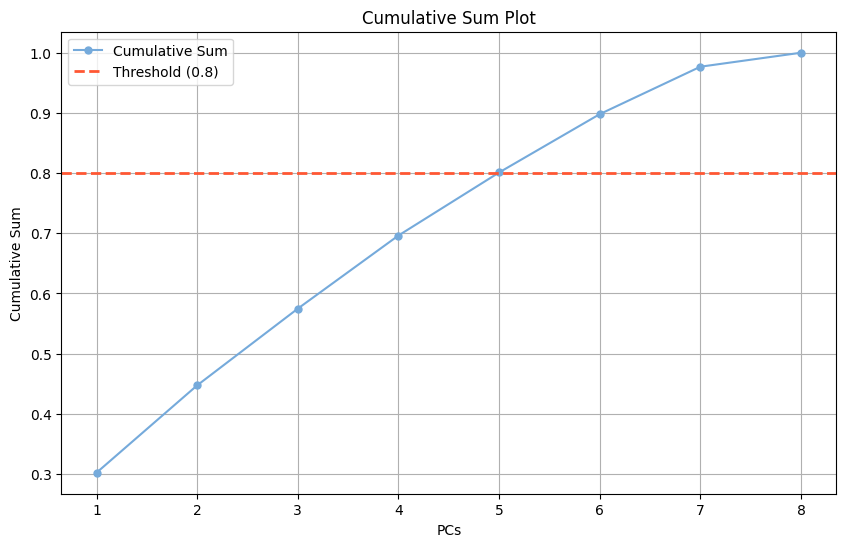

In [42]:
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

# Defining schema
schema = StructType([
    StructField("Index", IntegerType(), nullable=False),
    StructField("CumulativeSum", FloatType(), nullable=False)
])

# Calculating cumulative sum
cumulative_sum = explained_variance.cumsum()

# Creating a DataFrame with the specified schema
plot_data = spark.createDataFrame([(i, float(val)) for i, val in enumerate(cumulative_sum, start=1)], schema)

# Converting Spark DataFrame to Pandas for plotting
plot_data_pd = plot_data.toPandas()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(plot_data_pd['Index'], plot_data_pd['CumulativeSum'], marker='o', color='#75AADB', markersize=5, label='Cumulative Sum')
plt.axhline(y=0.8, linestyle='--', color='#FF5733', linewidth=2, label='Threshold (0.8)')
plt.title('Cumulative Sum Plot')
plt.xlabel('PCs')
plt.ylabel('Cumulative Sum')
plt.xticks(range(1, len(explained_variance) + 1))  
plt.legend()
plt.grid(True)
plt.show()


The result of the decision tree delivers more insight into the target variable spread without need for balancing.

In [102]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from matplotlib import pyplot as plt

# Subsetting for both levels
fhd_df_omit_0 = fhd_df.filter(fhd_df['TenYearCHD'] == 0)
fhd_df_omit_1 = fhd_df.filter(fhd_df['TenYearCHD'] == 1)

# Counting the number of rows for each level
n_rows_fhd_0 = fhd_df_omit_0.count()
n_rows_fhd_1 = fhd_df_omit_1.count()

# Sampling 70% for training set
training_fhd_omit_0 = fhd_df_omit_0.sampleBy('TenYearCHD', fractions={0: 0.7, 1: 0.7}, seed=1001)
training_fhd_omit_1 = fhd_df_omit_1.sampleBy('TenYearCHD', fractions={0: 0.7, 1: 0.7}, seed=1001)

# Separating the data
test_fhd_omit_0 = fhd_df_omit_0.subtract(training_fhd_omit_0)
test_fhd_omit_1 = fhd_df_omit_1.subtract(training_fhd_omit_1)

# Rejoining them
training_fhd_omit = training_fhd_omit_0.union(training_fhd_omit_1)
test_fhd_omit = test_fhd_omit_0.union(test_fhd_omit_1)

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="keep") for col in ["gender", "education"]]
pipeline = Pipeline(stages=indexers)
training_data_indexed = pipeline.fit(training_fhd_omit).transform(training_fhd_omit)
test_data_indexed = pipeline.fit(test_fhd_omit).transform(test_fhd_omit)

# Drop the existing "features" column
training_data_indexed = training_data_indexed.drop("features")
test_data_indexed = test_data_indexed.drop("features")

# Define the feature columns
feature_columns = ['age', 'sysBP', 'diaBP', 'BMI', 'gender_index', 'education_index', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
training_data = assembler.transform(training_data_indexed)
test_data = assembler.transform(test_data_indexed)

# Define the target column
target_column = 'TenYearCHD'

# Train the decision tree classifier
dt = DecisionTreeClassifier(labelCol=target_column, featuresCol="features")
dt_model = dt.fit(training_data)

# Make predictions
predictions = dt_model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol=target_column, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Visualize the decision tree
print("Learned classification tree model:")
print(dt_model.toDebugString)
plt.figure(figsize=(20, 10))
_ = dt_model.featureImportances

plt.show()


Accuracy: 0.8333333333333334
Learned classification tree model:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_c6eab1e4c77c, depth=5, numNodes=41, numClasses=2, numFeatures=10
  If (feature 0 <= 48.5)
   If (feature 2 <= 107.75)
    If (feature 1 <= 138.75)
     Predict: 0.0
    Else (feature 1 > 138.75)
     If (feature 3 <= 21.939999999999998)
      If (feature 2 <= 98.75)
       Predict: 0.0
      Else (feature 2 > 98.75)
       Predict: 1.0
     Else (feature 3 > 21.939999999999998)
      Predict: 0.0
   Else (feature 2 > 107.75)
    If (feature 5 in {0.0})
     If (feature 9 <= 0.5)
      Predict: 0.0
     Else (feature 9 > 0.5)
      Predict: 1.0
    Else (feature 5 not in {0.0})
     If (feature 6 <= 0.5)
      If (feature 0 <= 46.5)
       Predict: 0.0
      Else (feature 0 > 46.5)
       Predict: 1.0
     Else (feature 6 > 0.5)
      Predict: 0.0
  Else (feature 0 > 48.5)
   If (feature 1 <= 143.25)
    If (feature 4 in {0.0})
     If (feature 2 <= 69.75)
      If

<Figure size 2000x1000 with 0 Axes>

PC1 and PC5 show the greatest differences in average values across the 2 cluster groups and will be used for the scatterplot.

In [103]:
# Fit the pipeline
pipeline_model = pipeline.fit(training_fhd_omit)

# Get the StringIndexerModel objects
indexer_models = pipeline_model.stages

# Loop through the indexer models to retrieve category labels
for i, col in enumerate(["gender", "education"]):
    print(f"Category labels for {col}:")
    indexer_model = indexer_models[i]
    category_labels = indexer_model.labels
    for j, label in enumerate(category_labels):
        print(f"Index {j} corresponds to {label}")


Category labels for gender:
Index 0 corresponds to female
Index 1 corresponds to male
Category labels for education:
Index 0 corresponds to Secondary School
Index 1 corresponds to Graduation
Index 2 corresponds to Post Graduation
Index 3 corresponds to PHD


Joining the tables.